In [ ]:
! pip install -q transformers
!pip install -q gradio
!sudo apt-get install git-lfs
!git lfs install
!pip install wandb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Git LFS initialized.


In [ ]:
import os
import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModel, ErnieForSequenceClassification
# pd.set_option('Display.max_colwidth',None)

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
torch.__version__

'2.1.0+cu118'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [ ]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')



wandb.init(project="Multi Label Classification of PubMed Articles (Paper Night Presentation)",name=f"Ernie-")

wandb: Currently logged in as: panagsyr (pngsr). Use `wandb login --relogin` to force relogin


If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [ ]:
dataset_Name='/content/drive/MyDrive/PubMed Multi Label Text Classification Dataset Processed.csv'

df= pd.read_csv(dataset_Name)
df.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0


In [ ]:
print("Total number of Articles extracted from Bioasq dataset are =",len(df))

Total number of Articles extracted from Bioasq dataset are = 50000


In [ ]:
print('Average Article length: ', df.abstractText.str.split().str.len().mean())
print('Stdev Article length: ', df.abstractText.str.split().str.len().std())

Average Article length:  192.05284
Stdev Article length:  76.74764082329723


In [ ]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)

Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


In [ ]:
%%time

counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

CPU times: user 3.35 ms, sys: 0 ns, total: 3.35 ms
Wall time: 3.32 ms


,Root Label,number of Abstract
0,A,23263
1,B,46577
2,C,26453
3,D,31074
4,E,39202
5,F,8885
6,G,33609
7,H,6069
8,I,5595
9,J,5531


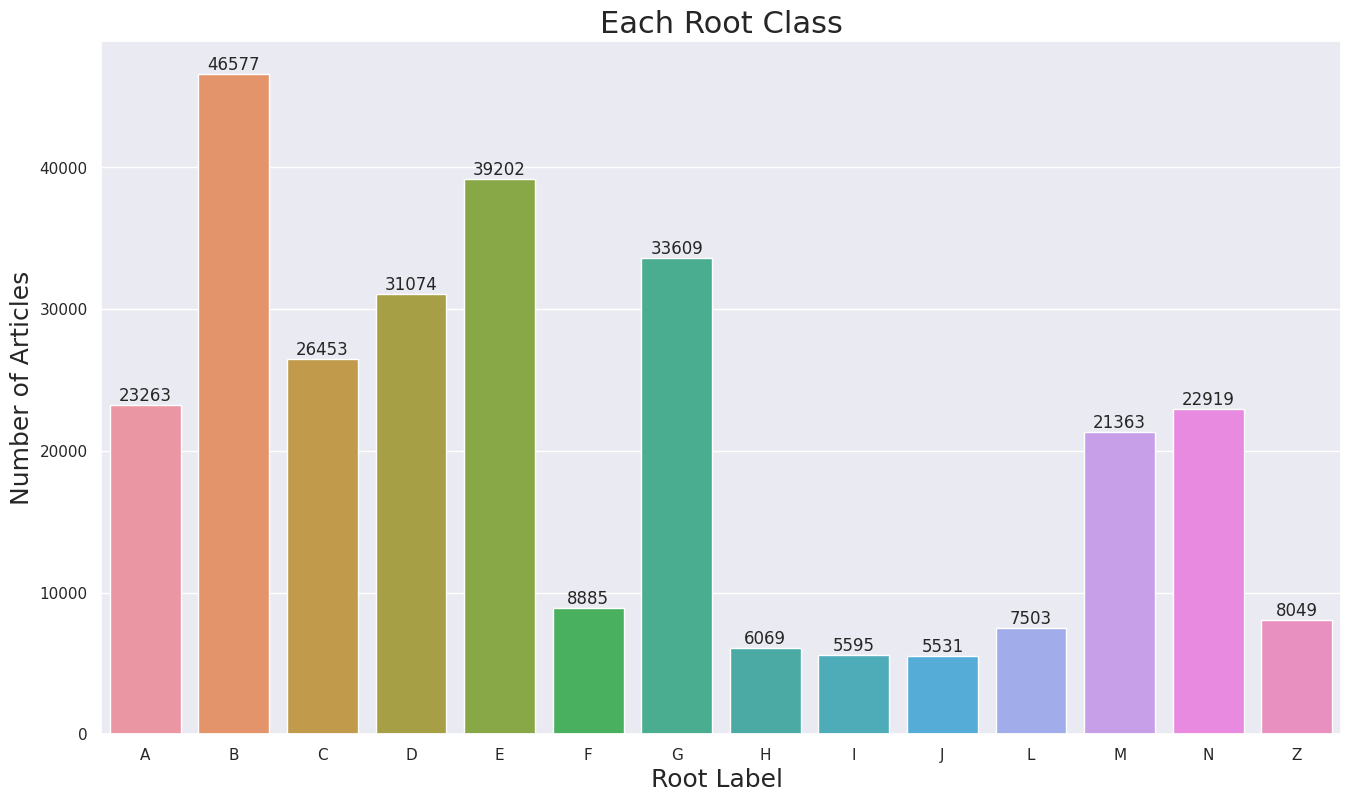

CPU times: user 389 ms, sys: 235 ms, total: 624 ms
Wall time: 354 ms


In [ ]:
%%time
import matplotlib.pyplot as plt
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
ax= sns.barplot(x = mesh_Heading_categories,y = df.iloc[:,6:].sum().values)
plt.title("Each Root Class", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Root Label ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,6:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [ ]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

print(df_train.shape)
print(df_test.shape)
del(df)

(40000, 20)
(10000, 20)


In [ ]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
31112,Neurofibromatosis associated with a coronary a...,A case of a patient with type 1 neurofibromato...,"['Aged', 'Coronary Aneurysm', 'Humans', 'Male'...",11144803,"[['M01.060.116.100'], ['C14.280.647.250.250', ...","['Named Groups [M]', 'Diseases [C]', 'Organism...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
48911,Phenolic constituents from Perovskia atriplici...,"Perovskoate, an isorinic acid derivative (1) a...","['Caffeic Acids', 'Catechols', 'Cholinesterase...",16644529,"[['D02.241.223.200.054'], ['D02.455.426.559.38...","['Chemicals and Drugs [D]', 'Analytical, Diagn...",0,1,0,1,...,0,1,0,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
16394,Motion artifact and background noise suppressi...,Optical coherence tomography (OCT) is a techni...,"['Algorithms', 'Angiography', 'Artifacts', 'Ar...",25089975,"[['G17.035', 'L01.224.050'], ['E01.370.350.700...","['Phenomena and Processes [G]', 'Information S...",0,0,0,0,...,0,1,0,0,0,1,0,1,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [ ]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.abstractText.values)

In [ ]:
%%time
max_length = 128
#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
tokenizer = AutoTokenizer.from_pretrained('nghuyong/ernie-2.0-base-en', do_lower_case=True)
#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

(…)se-en/resolve/main/tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

(…)nie-2.0-base-en/resolve/main/config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

(…)ernie-2.0-base-en/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)-en/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 1min 1s, sys: 1.82 s, total: 1min 3s
Wall time: 13.2 s


In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [ ]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
model = ErnieForSequenceClassification.from_pretrained('nghuyong/ernie-2.0-base-en', num_labels=num_labels)
#model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
##model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)
#model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Pushed to Cuda for Training
CPU times: user 2.03 s, sys: 1.03 s, total: 3.06 s
Wall time: 4.39 s


In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [ ]:
%%time

# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 12

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation

        train_loss_set.append(loss.item())

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)

    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.40660546654462815


Epoch :   8%|▊         | 1/12 [03:27<37:59, 207.26s/it]

F1 Validation Accuracy:  84.02203856749313
Flat Validation Accuracy:  9.375


Train loss: 0.33098050755262376


Epoch :  17%|█▋        | 2/12 [06:55<34:37, 207.77s/it]

F1 Validation Accuracy:  84.99999999999999
Flat Validation Accuracy:  14.0625


Train loss: 0.3061144217848778


Epoch :  25%|██▌       | 3/12 [10:23<31:11, 207.94s/it]

F1 Validation Accuracy:  85.35564853556485
Flat Validation Accuracy:  12.5


Train loss: 0.290449619948864


Epoch :  33%|███▎      | 4/12 [13:51<27:44, 208.06s/it]

F1 Validation Accuracy:  85.00687757909216
Flat Validation Accuracy:  15.625


Train loss: 0.2779645367860794


Epoch :  42%|████▏     | 5/12 [17:19<24:16, 208.10s/it]

F1 Validation Accuracy:  84.9655172413793
Flat Validation Accuracy:  18.75


Train loss: 0.267305565237999


Epoch :  50%|█████     | 6/12 [20:48<20:48, 208.12s/it]

F1 Validation Accuracy:  84.44444444444446
Flat Validation Accuracy:  18.75


Train loss: 0.25647204273939134


Epoch :  58%|█████▊    | 7/12 [24:16<17:20, 208.14s/it]

F1 Validation Accuracy:  84.51882845188285
Flat Validation Accuracy:  18.75


Train loss: 0.24641936576366424


Epoch :  67%|██████▋   | 8/12 [27:44<13:52, 208.14s/it]

F1 Validation Accuracy:  84.7645429362881
Flat Validation Accuracy:  17.1875


Train loss: 0.23655915039777756


Epoch :  75%|███████▌  | 9/12 [31:12<10:24, 208.11s/it]

F1 Validation Accuracy:  84.99999999999999
Flat Validation Accuracy:  17.1875


Train loss: 0.22694089472293855


Epoch :  83%|████████▎ | 10/12 [34:40<06:56, 208.10s/it]

F1 Validation Accuracy:  84.18156808803302
Flat Validation Accuracy:  17.1875


Train loss: 0.21688380160927773


Epoch :  92%|█████████▏| 11/12 [38:08<03:28, 208.08s/it]

F1 Validation Accuracy:  85.0889192886457
Flat Validation Accuracy:  18.75


Train loss: 0.20745730584859848


Epoch : 100%|██████████| 12/12 [41:36<00:00, 208.05s/it]

F1 Validation Accuracy:  84.44444444444446
Flat Validation Accuracy:  18.75




train_loss,█▅▄▄▃▃▃▂▂▂▁▁
val_f1_accuracy,▁▆█▆▆▃▄▅▆▂▇▃
val_flat_accuracy,▁▅▃▆███▇▇▇██
train_loss,0.20746
val_f1_accuracy,84.44444
val_flat_accuracy,18.75


CPU times: user 41min 46s, sys: 2.15 s, total: 41min 48s
Wall time: 41min 42s


In [ ]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

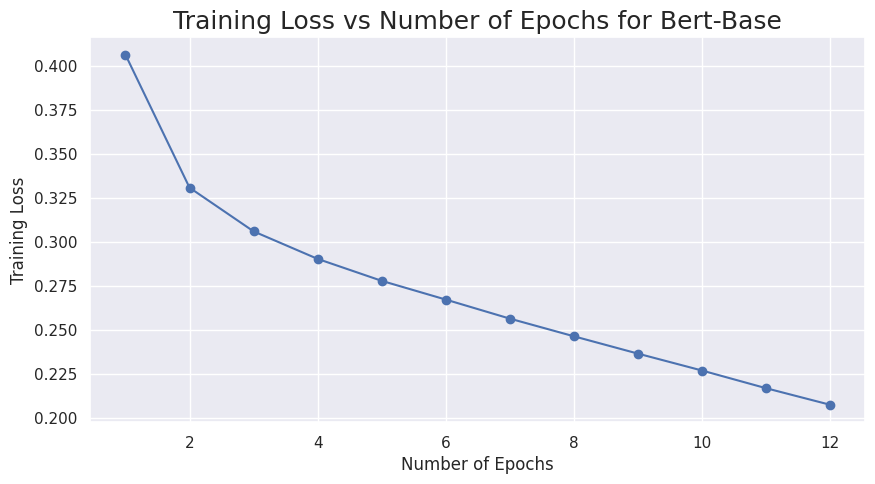

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

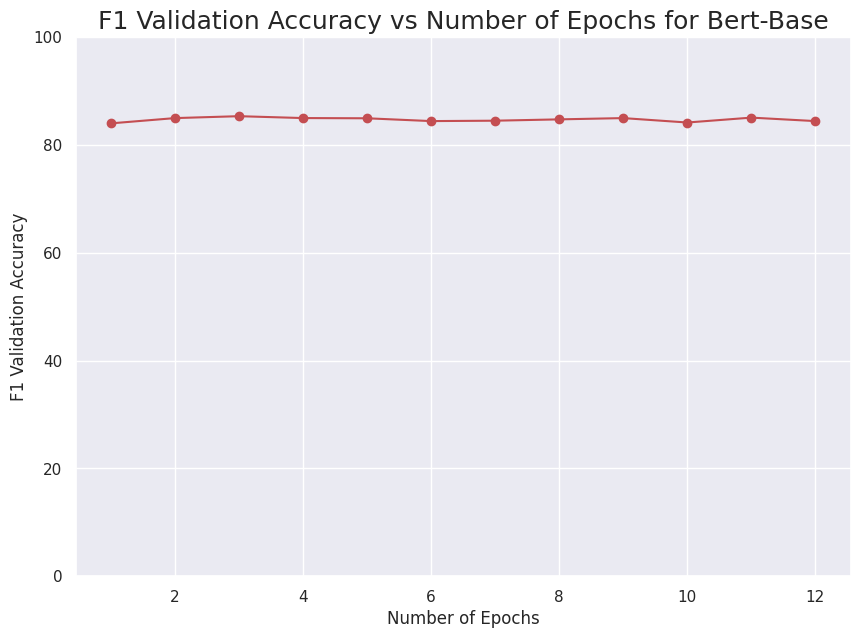

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

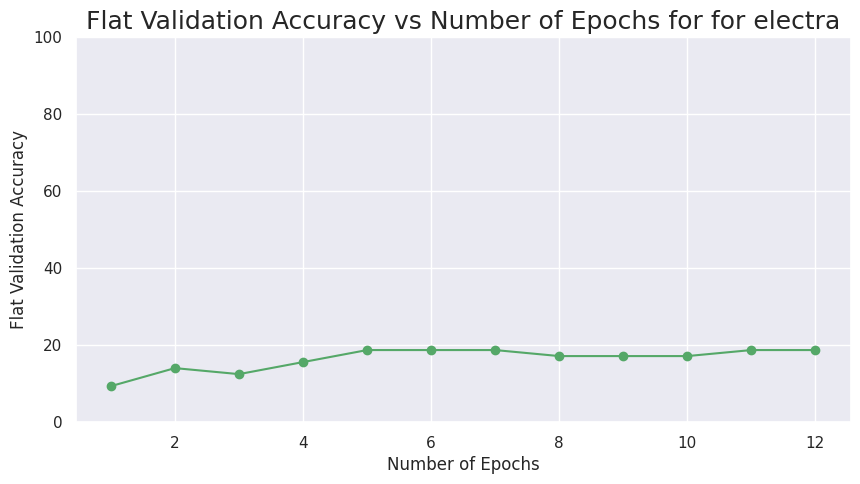

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for electra",fontsize=18)
ax.set_ylim(0, 100)

In [ ]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [ ]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids,  attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [ ]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()



Test F1 Accuracy:  0.8461212078353723
Test Flat Accuracy:  0.1605 

              precision    recall  f1-score   support

           A       0.79      0.78      0.78      4609
           B       0.97      0.98      0.97      9250
           C       0.87      0.88      0.87      5206
           D       0.90      0.94      0.92      6259
           E       0.82      0.92      0.87      7778
           F       0.85      0.68      0.76      1767
           G       0.83      0.87      0.85      6799
           H       0.58      0.19      0.28      1221
           I       0.73      0.56      0.63      1068
           J       0.66      0.54      0.60      1110
           L       0.65      0.47      0.55      1491
           M       0.88      0.88      0.88      4232
           N       0.82      0.75      0.78      4602
           Z       0.73      0.72      0.72      1558

   micro avg       0.85      0.84      0.85     56950
   macro avg       0.79      0.73      0.75     56950
weighted avg

In [ ]:
df_report.to_csv('Classification_Report.csv',index=False)

In [ ]:
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')